In [129]:
import xlrd, xlwt
import matplotlib.pyplot as plt
import numpy
import numpy as np
import math
import scipy
import scipy.optimize

#errors
def get_a_b(X, Y, sdvig=5):
    global precision
    sdvig = len(X)
    XY = [[X[j][i]*Y[j][i] for i in range(len(X[j]))] for j in range(sdvig)]
    X2 = [[X[j][i]*X[j][i] for i in range(len(X[j]))] for j in range(sdvig)]
    Y2 = [[Y[j][i]*Y[j][i] for i in range(len(X[j]))] for j in range(sdvig)]

    B = [(sum(XY[j])/len(XY[j]) - (sum(X[j])/len(X[j]))*(sum(Y[j])/len(Y[j])))/(sum(X2[j])/len(X2[j])-(sum(X[j])/len(X[j]))*(sum(X[j])/len(X[j]))) for j in range(sdvig)]
    #B = [for j in range(sdvig)]

    A = [sum(Y[j])/len(Y[j]) - B[j]*(sum(X[j])/len(X[j])) for j in range(sdvig)]
    SIGMA_B = [(1/(len(Y[j]))**0.5) * (( (sum(Y2[j])/len(Y2[j])-(sum(Y[j])/len(Y[j]))**2)/((sum(X2[j])/len(X2[j])-(sum(X[j])/len(X[j]))**2)) - B[j]**2 )**0.5) for j in range(sdvig)]
    SIGMA_A = [SIGMA_B[j] * (((sum(X2[j])/len(X2[j])-(sum(X[j])/len(X[j]))**2)) - B[j]**2 )**0.5 for j in range(sdvig)]

    for i in range(sdvig):
        print(
            f"y = x ∙ (",
            f"%.{precision}f" % (B[i]),
            " ± ",
            f"%.{precision}f" % abs(SIGMA_B[i]),
            ") + (",
            f"%.{precision}f" % (A[i]),
            "± ",
            f"%.{precision}f" % abs(SIGMA_A[i]),
            ")")
    return A, B, [abs(item) for item in SIGMA_A], [abs(item) for item in SIGMA_B]


def smart_plot(X, Y, XERR, YERR, inv = 0, xlabel = "X", ylabel = "Y", description_arr = [], c_range=[0, 0]):
    colors = ["BLACK",
              "RED",
              "GREEN",
              "BLUE",
              "VIOLET",
              "YELLOW",
              "CORAL",
              "GRAY"]
    dot_colors = ["ko", "ro", "go", "bo", "mo", "yo", "co", "bo"]
    _first_litter_value, s_legend = plt.subplots()
    print("Start smart plot")
    
    c_X, c_Y = [], []
    for i in range(len(X)):
        c_X_i, start_p, end_p = c_cut(X[i], c_range)
        c_Y_i = Y[i][start_p:end_p]
        c_X.append(c_X_i)
        c_Y.append(c_Y_i)
    A, B, SIGMA_A, SIGMA_B = get_a_b(c_X, c_Y, len(c_X))
    l_array = []
    
    for i in range(len(X)):
        s_legend.errorbar(X[i], Y[i],  xerr=XERR[i], yerr=YERR[i], fmt=dot_colors[i], ecolor=colors[i],linewidth=0.5)
        dens, = plt.plot(X[0], Y[0], dot_colors[i], zorder=1)
        min_all = min(c_X[i])
        max_all = max(c_X[i])
        xx = np.arange(min_all*0.99,
                       max_all*1.01,
                       (max_all-min_all)/1000)
        if inv != 1:
            if inv == 0:
                l, = plt.plot(xx, xx*B[i] + A[i], color = colors[i])
            elif inv == "exp":
                arr = (scipy.optimize.curve_fit(lambda t,a,b,c: a*numpy.exp(b*t)+c,
                                                c_X[i],  c_Y[i],
                                                maxfev=5000)[0])
                # print(f"y = {arr[0]}∙exp({arr[1]}∙x) + {arr[2]} ")
                print(
                    f"y = ",
                    f"%.{precision}f" % (arr[0]),
                    "∙ exp(x ∙ ",
                    f"%.{precision}f" % (arr[1]), 
                    ") + (",
                    f"%.{precision}f" % (arr[2]),
                    ")")
                l, = plt.plot(xx, arr[0]*np.exp(arr[1]*xx) + arr[2], color = colors[i])
            elif inv[0:4] == "poly":
                inv_N = int(inv[5:len(inv)])
                L_array = [(lambda t,a,b: a*t**1+b),
                           (lambda t,a,b,c: a*t**2+b*t**1+c),
                           (lambda t,a,b,c,d: a*t**3+b*t**2+c*t**1+d),
                           (lambda t,a,b,c,d,e: a*t**4+b*t**3+c*t**2+d*t**1+e),
                           (lambda t,a,b,c,d,e,f: a*t**5+b*t**4+c*t**3+d*t**2+e*t+f),
                           (lambda t,a,b,c,d,e,f,g: a*t**6+b*t**5+c*t**4+d*t**3+e*t**2+f*t+g),
                           (lambda t,a,b,c,d,e,f,g,h: a*t**7+b*t**6+c*t**5+d*t**4+e*t**3+f*t**2+g*t**1+h),
                           (lambda t,a,b,c,d,e,f,g,h,k: a*t**8+b*t**7+c*t**6+d*t**5+e*t**4+f*t**3+g*t**2+h*t+k),]
                arr = (scipy.optimize.curve_fit(L_array[inv_N-1],
                                                c_X[i],  c_Y[i],
                                                maxfev=5000)[0])
                l_arr = lambda i: arr[i]*np.power(xx, len(arr) - i - 1)
                L_S_array = []
                try:
                    L_S_array = [l_arr(0)]
                    try:
                        L_S_array = [l_arr(0) + l_arr(1)]
                        try:
                            L_S_array = [l_arr(0) + l_arr(1) + l_arr(2)]
                            try:
                                L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3)]
                                try:
                                    L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4)]
                                    try:
                                        L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4) + l_arr(5)]
                                        try:
                                            L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4) + l_arr(5) + l_arr(6)]
                                            try:
                                                L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4) + l_arr(5) + l_arr(6) + l_arr(7)]
                                                try:
                                                    L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4) + l_arr(5) + l_arr(6) + l_arr(7) + l_arr(8)]
                                                except:
                                                    L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4) + l_arr(5) + l_arr(6) + l_arr(7)]
                                            except:
                                                L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4) + l_arr(5) + l_arr(6)]
                                        except:
                                            L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4) + l_arr(5)]
                                    except:
                                        L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3) + l_arr(4)]
                                except:
                                    L_S_array = [l_arr(0) + l_arr(1) + l_arr(2) + l_arr(3)]
                            except:
                                L_S_array = [l_arr(0) + l_arr(1) + l_arr(2)]
                        except:
                            L_S_array = [l_arr(0) + l_arr(1)]
                    except:
                        L_S_array = [l_arr(0)]
                except:
                     L_S_array = []
                l, = plt.plot(xx, L_S_array[0], color = colors[i])
        if (i!=1):
            l_array.append(dens)
        if inv != 1:
            l_array.append(l)
    if (len(description_arr) > 0):
        label_array = [description_arr[0]] + ["y = x$\cdot$" + 
                                       (f"%.{precision}f" % (B[inter])) + ("+" if (A[inter] > 0) else "-") + 
                                       (f"%.{precision}f" % (A[inter])) + "  " + description_arr[inter+1] for inter in range(len(X))]    
        plt.legend(l_array, label_array, loc='upper right', fontsize=9)

    s_legend.grid()
    s_legend.set_xlabel(xlabel)
    s_legend.set_ylabel(ylabel)

def c_cut(c_array, c_range):
    start_index = 0
    end_index = len(c_array)-1
    min_all = min(c_array)
    max_all = max(c_array)
    for i in range(len(c_array)):
        if c_array[i] >= min_all + (max_all-min_all)*c_range[0]:
            start_index = i
            break
    for j in range(len(c_array)):
        if c_array[j] >= max_all - (max_all-min_all)*c_range[1]:
            end_index = j-1
            break
    return c_array[start_index: 1+end_index], start_index, 1+end_index 
    
def to_number(string_index):
    res_index = 0
    for i in range(len(string_index)):
        item = string_index[i]
        ord_index = ord(item)
        if ord_index < 95:
            ord_index = ord_index - (ord('A')-1)
        else:
            ord_index = ord_index - (ord('a')-1)
        res_index += 26 ** (len(string_index)-i-1) * ord_index
    return res_index - 1

class Point:
    x = 0
    y = 0
    def __init__(self, x, y):
        self.x = to_number(x)
        self.y = y

class Arr_excel:
    p_start = Point("A", 0)
    p_end = Point("D", 0)
    
    def __init__(self, x1, y1, x2, y2):
        self.p_start = Point(x1, y1)
        self.p_end = Point(x2, y2)
        # A = Arr_excel("A", 0, "D", 0)
        
class Graph_excel:
    # Это график: есть ось X, есть Y: сначала заполняем поля графика по X а потом по Y
    # Для того чтобы создать график заполняем начальную точку: нам нужно указать 
    # стартовую точку оси X в таблице Excel и Y и после этого нужно указать конечную 
    # точку массива
    X = Arr_excel(
            "A", 0,
            "A", 10),
    Y = Arr_excel(
            "B",0,
            "B",10)

    
    def fill_data(self, data):
        # fill X
        x_1 = self.X.p_start.x
        y_1 = self.X.p_start.y
        x_2 = self.X.p_end.x
        y_2 = self.X.p_end.y
        pre_X_ARR = [[(data(y_1+i)[j+x_1]) for i in range(y_2-y_1+1)] for j in range(x_2-x_1+1)]
        if len(pre_X_ARR) > 1:
            self.X_ARR = [item[0] for item in pre_X_ARR]
        else:
            self.X_ARR = pre_X_ARR[0]
            
        # fill Y
        x_1 = self.Y.p_start.x
        y_1 = self.Y.p_start.y
        x_2 = self.Y.p_end.x
        y_2 = self.Y.p_end.y
        pre_Y_ARR = [[(data(y_1+i)[j+x_1]) for i in range(y_2-y_1+1)] for j in range(x_2-x_1+1)]
        if len(pre_Y_ARR) > 1:
            self.Y_ARR = [item[0] for item in pre_Y_ARR]
        else:
            self.Y_ARR = pre_Y_ARR[0]
    
    def __init__(self, 
                 start_X_x, start_X_y, 
                 end_X_x, end_X_y, 
                 start_Y_x, start_Y_y, 
                 end_Y_x, end_Y_y,):
        self.X = Arr_excel(
            start_X_x, start_X_y-1,
            end_X_x, end_X_y-1)
        
        self.Y = Arr_excel(
            start_Y_x, start_Y_y-1,
            end_Y_x, end_Y_y-1)
        # A = Graph_excel("A", 0, "D", 0, "A", 1, "D", 1)
        # Нам нужно выбить начальную точку и конечную для каждого из массивов,
        # можно вбивать как столбцы так и строки - главное чтобы была только одна 
        # варьируемая координата
        self.X_ARR = []
        self.Y_ARR = []

Start smart plot
y = x ∙ ( -0.415  ±  0.424 ) + ( 3.855 ±  0.444 )


<Figure size 432x288 with 0 Axes>

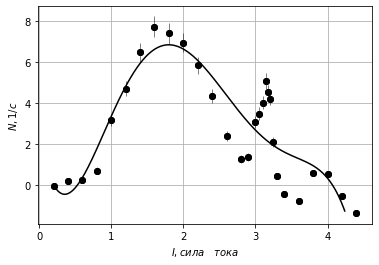

In [132]:
# Основные настройки к эксель талице
file_name = "C://MIPT//Labs//542//542.xls"
number_of_sheet = 1


rb = xlrd.open_workbook(file_name)
sheet = rb.sheet_by_index(number_of_sheet - 1)

# указываем графики: их границы:  начальная и конечная точки, X и Y оси
G_1 = Graph_excel("D", 6, "D", 34, "F", 6, "F", 34)
G_1.fill_data(sheet.row_values)
G_1_E = Graph_excel("G", 6, "G", 34, "H", 6, "H", 34)
G_1_E.fill_data(sheet.row_values)

X=[G_1.X_ARR]
Y=[G_1.Y_ARR]


#error bars - указывем ошибки к соответствующим величинам
XERR = [G_1_E.Y_ARR]
YERR = [G_1_E.X_ARR]



# точность с которой расчитываеются величины
precision = 3

# пояснение к осям графика
xlabel="$I, сила\quadтока$"
ylabel="$N, 1/c$"

plt.figure()
smart_plot(X=X,
           Y=Y,
           XERR=XERR,
           YERR=YERR, 
           inv="poly_5",
           xlabel=xlabel,
           ylabel=ylabel,
           description_arr=[],
           c_range=[0, 0])
plt.show()

Start smart plot
y = x ∙ ( -0.615  ±  0.022 ) + ( 361.668 ±  3.107 )


<Figure size 432x288 with 0 Axes>

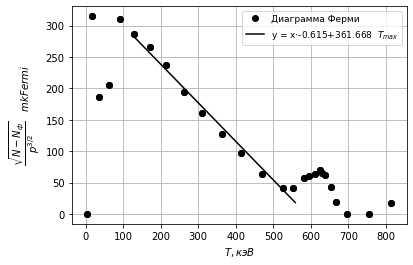

In [137]:
# указываем графики: их границы:  начальная и конечная точки, X и Y оси
G_2 = Graph_excel("J", 6, "J", 31, "K", 6, "K", 31)
G_2.fill_data(sheet.row_values)

X_2=[G_2.X_ARR]
Y_2=[G_2.Y_ARR]

#error bars - указывем ошибки к соответствующим величинам
XERR_2 = [[ 0.001 for i in range(len(X_2[j]))] for j in range(len(X_2))]
YERR_2 = [[ 0.001 for i in range(len(Y_2[j]))] for j in range(len(Y_2))]

# точность с которой расчитываеются величины
precision = 3

# пояснение к осям графика
xlabel="$T, кэВ$"
ylabel="$\dfrac{\sqrt{N-N_{ф}}}{p^{3/2}} \quad mkFermi$"

plt.figure()
smart_plot(X=X_2,
           Y=Y_2,
           XERR=XERR_2,
           YERR=YERR_2, 
           inv=0,
           xlabel=xlabel,
           ylabel=ylabel,
           description_arr=["Диаграмма Ферми", "$T_{max}$"],
           c_range=[0.12, 0.3])
plt.show()